In [137]:
from math import isnan
from functools import total_ordering
import calendar
import zipfile
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from datetime import datetime
import datetime
import warnings
import common_func as cf
warnings.filterwarnings('ignore')

Max days option expiration is 945
Max days option expiration is 945


In [166]:
def should_execute(spot, expired_today, trace):
    total_minus = 0
    executed = 0
    for option in expired_today:
        strike = option['Strike']
        option_type = option['Type']
        if option_type == 'call' and strike < spot:
            minus = strike - spot
            executed = executed + 1
            total_minus = total_minus + minus
        elif option_type == 'put' and strike > spot:
            minus = spot - strike
            executed = executed + 1
            total_minus = total_minus + minus

    total_len = len(expired_today)
    if total_len > 0 and trace:
        print(f"From {total_len} expired options only {executed} were executed. Total minus {total_minus}")

    return total_minus

def remove_expired_options(portfolio_list: list, date: datetime.datetime):
    return list(filter(lambda x: x['Expiration'] != date, portfolio_list))

def get_expired_options(portfolio_list: list, date: datetime.datetime):
    return list(filter(lambda x: x['Expiration'] == date, portfolio_list))

def calculate_delta_port(portfolio_list: list):
    delta_total = 0
    for p in portfolio_list:
        delta_total = delta_total + p['Delta']

    return delta_total

def visualize(b, caption):
    lists = sorted(b.items())
    x, y = zip(*lists)
    plt.title(caption)
    plt.plot(x, y)
    plt.show()

def trading(call_put, max_days=100, trace=True):
    balance = {0: .0}
    delta_tracing = {0: .0}
    option_number = {0: 0}
    min_expiration = 1
    max_expiration = 15

    portfolio = []
    max_delta = 1.5

    current_date = datetime.datetime.now()
    i = 0
    for (_, call), (_, put) in call_put:
        if i > max_days:
            break

        date = call['DataDate']
        if date != current_date:
            if trace:
                print(f'Next date {date}')
            current_date = date
            i = i + 1
            balance[i] = balance[i - 1]
            delta_tracing[i] = delta_tracing[i - 1]
            option_number[i] = option_number[i - 1]

            current_spot = call['UnderlyingPrice']
            expired_today = get_expired_options(portfolio, date)
            portfolio = remove_expired_options(portfolio, date)

            delta_tracing[i] = delta_tracing[i] - calculate_delta_port(expired_today)
            option_number[i] = option_number[i] - len(expired_today)
            balance[i] = balance[i] + should_execute(current_spot, expired_today, trace)

        days = call['Days']
        if days > max_expiration or days < min_expiration:
            continue

        call_delta = call['Delta']
        call_strike = call['Strike']

        put_delta = put['Delta']
        put_strike = put['Strike']

        total_delta = call_delta + put_delta

        new_delta = delta_tracing[i] + total_delta
        if max_delta < new_delta:
            continue

        if call_strike > put_strike and call_delta < abs(put_delta) and trace:
            print("WARNING Call strike is greater than put, while delta's not")
            print(call)
            print(put)
            continue

        if call_strike < put_strike:
            continue


        delta_tracing[i] = new_delta
        call_bid = call['Bid']
        put_bid = put['Bid']
        balance[i] = balance[i] + call_bid + put_bid
        if trace:
            print(f"Total income: {call_bid + put_bid}, Total: {balance[i]}")

        option_number[i] = option_number[i] + 2

        portfolio.append(call)
        portfolio.append(put)

    # for i in range(0, i_range):
    #     # for j in range(0, j_range):
    #     #     print(df_calls.values[i,j],df_puts.values[i,j])
    #     print(df_calls.at[i,1]) # ,df_puts.at[i,0])
    #     break
    visualize(balance, "Daily balance")
    visualize(delta_tracing, "Daily delta")
    visualize(option_number, "Daily portfolio option count")

Simple simulation for AMZN
Max days option expiration is 858
Max days option expiration is 858


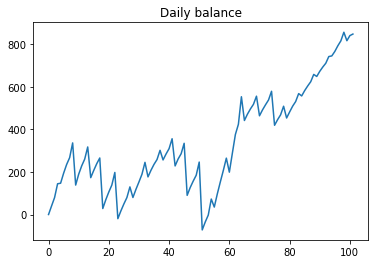

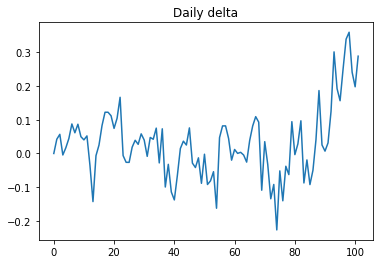

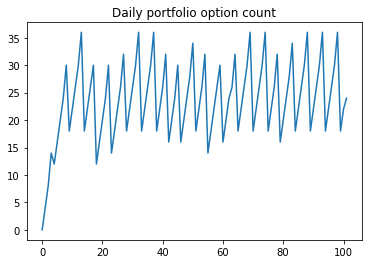

Simple simulation for GOOGL
Max days option expiration is 858
Max days option expiration is 858


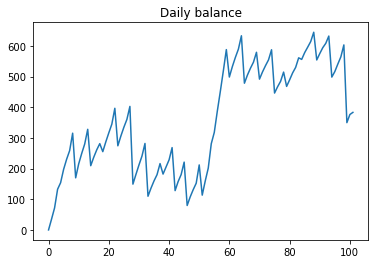

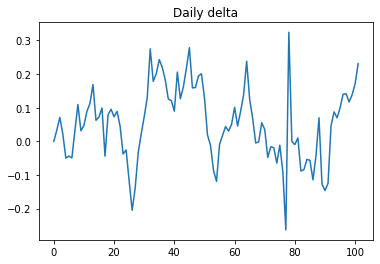

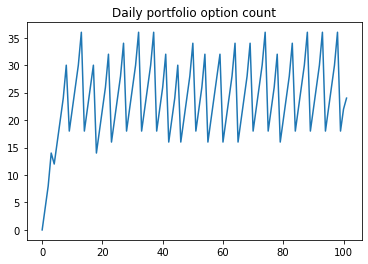

Simple simulation for NFLX
Max days option expiration is 858
Max days option expiration is 858


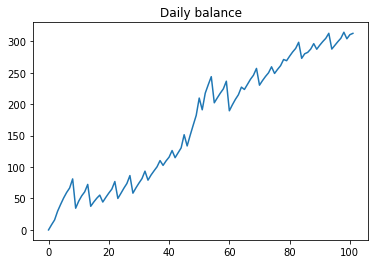

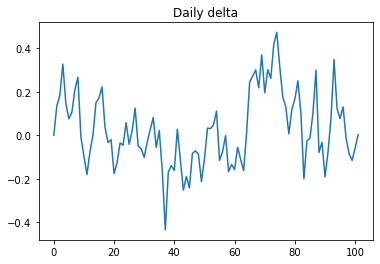

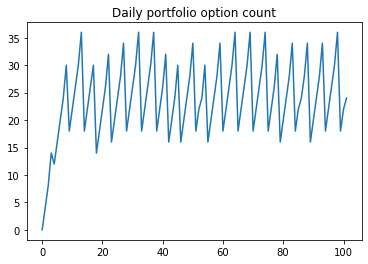

Simple simulation for MSFT
Max days option expiration is 945
Max days option expiration is 945


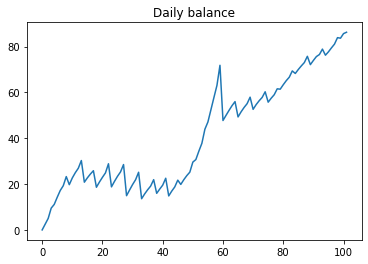

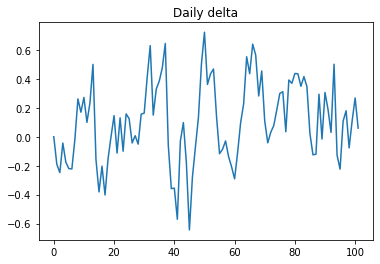

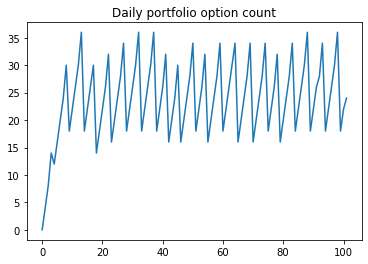

Simple simulation for FB
Max days option expiration is 858
Max days option expiration is 858


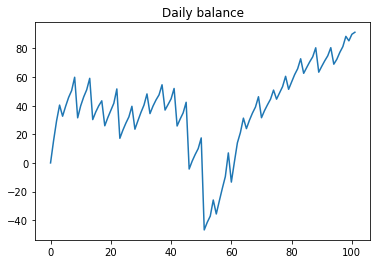

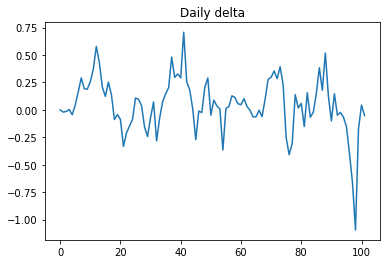

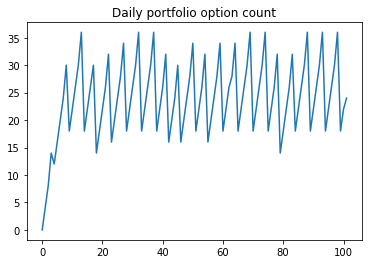

Simple simulation for BA
Max days option expiration is 858
Max days option expiration is 858


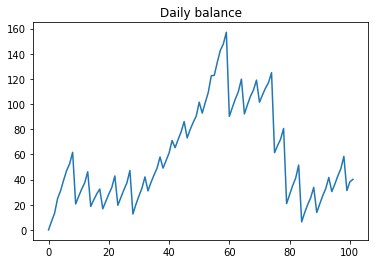

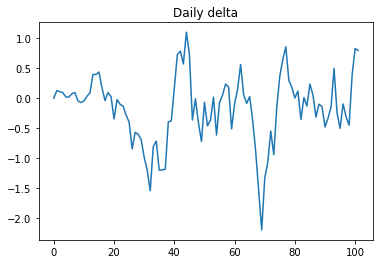

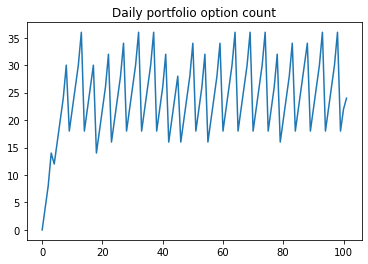

In [168]:
assets = ['AMZN', 'GOOGL', 'NFLX', 'MSFT', 'FB', 'BA']
for asset_name in assets:
    print(f"Simple simulation for {asset_name}")
    #simulate_simple_trading(asset_name)

    df_put = cf.load(asset_name, "put")
    df_put_days = cf.select_closest_dn_option_max_expiration_days(df_put, 0.5)

    df_call = cf.load(asset_name, "call")
    df_call_days = cf.select_closest_dn_option_max_expiration_days(df_call, -0.5)

    call_puts = zip(df_call_days.iterrows(), df_put_days.iterrows())
    trading(call_puts, max_days=100, trace=False)